# Amazon Reviews for SA fine-grained 5 clases CSV


In [88]:
import seaborn as sb
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import re
import contractions

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')
nltk.download('vader_lexicon')

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


from textblob import TextBlob
from tqdm import tqdm

pd.options.mode.chained_assignment = None
from wordcloud import WordCloud


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/beatrizag__/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/beatrizag__/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/beatrizag__/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/beatrizag__/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/beatrizag__/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Dataset


In [4]:
train_df = pd.read_csv('../docs/train.csv').dropna()
test_df = pd.read_csv('../docs/test.csv').dropna()

In [5]:
# Shorten the number of samples from every class_index type (n = 200000)

classes = []
n_samples = 10000

for i in range(1, 6):
    classes.append(train_df.query(f'class_index == {i}').sample(n=n_samples))

train_df_s = pd.concat(classes)
train_df_s.reset_index(drop=True, inplace=True)

train_df_s['review_full']= train_df_s['review_title'] + ' ' + train_df_s['review_text']



## Exploratory analysis


class distribution, word distribution per class based on TF-IDF, and so on

In [6]:
# checking for presence of null values that might interfere with data processing
train_df.isna().sum()

class_index     0
review_title    0
review_text     0
dtype: int64

Text(0.5, 1.0, 'Rating Distribution')

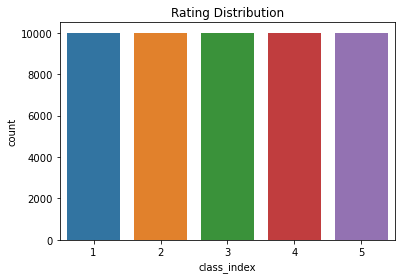

In [7]:
sb.countplot(x='class_index', data=train_df_s)
plt.title('Rating Distribution')


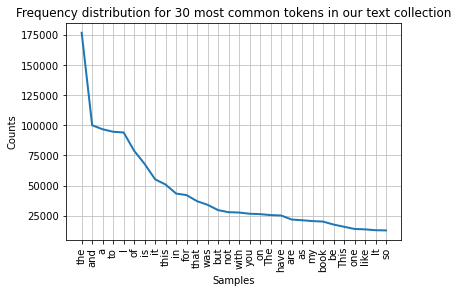

<AxesSubplot:title={'center':'Frequency distribution for 30 most common tokens in our text collection'}, xlabel='Samples', ylabel='Counts'>

In [8]:
c = " ".join([w for w in train_df_s['review_full']])

fdist_filtered = FreqDist([ w for w in c.split()])
fdist_filtered.plot(30,title='Frequency distribution for 30 most common tokens in our text collection')


In [9]:
def sentiment_analysis(string):
    sentences = TextBlob(string).sentences
    sentiments = [s.sentiment.polarity for s in sentences]
    return sum(sentiments)/len(sentiments)

<AxesSubplot:xlabel='class_index', ylabel='sentiment'>

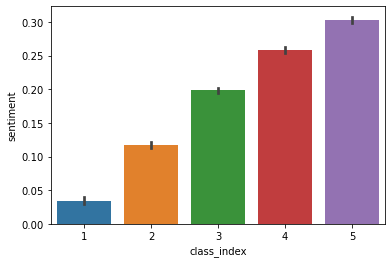

In [79]:
train_df_s['sentiment'] = train_df_s['review_title'] 
train_df_s['weight'] = train_df_s['review_title'] 

for i, review_full in enumerate(train_df_s['review_full']):
    sentiment = sentiment_analysis(review_full)
    train_df_s['sentiment'][i] = sentiment
    #train_df_s['weight'][i] = 1 - abs(((sentiment + 1) / 2) - (train_df_s['class_index'][i] / 5))

sb.barplot(data=train_df_s, x='class_index', y='sentiment')

## Preprocess data


In [11]:
stop_words = list(nltk.corpus.stopwords.words('english'))
stop_words.remove('not')
stop_words.remove('no')
stop_words.extend(['book','movie','product','one','time','cd','dvd'])

words = list(nltk.corpus.words.words())
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def handle_negation(string_array):
    string = ''
    i = 0
    while(i < (len(string_array) - 1)):
      if (string_array[i] == 'not'):
        string = string + ' ' + 'NOT_' + string_array[i + 1] 
        i += 1
      else:
        string = string + ' ' + string_array[i]
      i += 1
    return string

def preprocess_data(string):
    string = string.lower()
    text_contractions = [contractions.fix(w) for w in string.split()]
    string = re.sub("[^a-zA-Z]", " ", " ".join(text_contractions))
    string_list = word_tokenize(string)
    text_stems = [stemmer.stem(w) for w in string_list if w not in stop_words]
    return handle_negation(text_stems)

In [28]:
for i, review_full in tqdm(enumerate(train_df_s['review_full'])):
    preprocess_text = preprocess_data(review_full)
    train_df_s['review_full'][i] = preprocess_text

train_df_s.head()

50000it [01:03, 791.73it/s]


,class_index,review_title,review_text,review_full,sentiment,weight
0,1,"""Mother of Storms"" it Ain't!",Disappointed doesn't even come close to my fee...,mother storm NOT_disappoint NOT_even come clo...,-0.391667,0 9.600000 1 9.600000 2 9...
1,1,Will work but,I tried this product to trim up some ceramic t...,work tri trim ceram tile cut tile took almost...,-0.05,0 3.636364 1 3.636364 2 3...
2,1,Everything that's wrong with music,"OK, look. There's a lot of reviews here that s...",everyth wrong music ok look lot review say ic...,-0.102273,0 4.018265 1 4.018265 2 4...
3,1,Not a great product,"This radio is sub-standard. I also own Eton, a...",NOT_great radio sub standard also eton enjoy ...,0.135417,0 2.719547 1 2.719547 2 2...
4,1,Only the price is right. You get what you pay ...,I am not impressed.I don't know what the other...,price right get pay NOT_impress NOT_know revi...,0.255102,0 2.338902 1 2.338902 2 2...


In [32]:
train_df_s

,class_index,review_title,review_text,review_full,sentiment,weight
0,1,"""Mother of Storms"" it Ain't!",Disappointed doesn't even come close to my fee...,mother storm NOT_disappoint NOT_even come clo...,-0.391667,0 0.895833 1 0.895833 2 0...
1,1,Will work but,I tried this product to trim up some ceramic t...,work tri trim ceram tile cut tile took almost...,-0.05,0 0.725 1 0.725 2 0.725 3...
2,1,Everything that's wrong with music,"OK, look. There's a lot of reviews here that s...",everyth wrong music ok look lot review say ic...,-0.112727,0 0.756364 1 0.756364 2 0...
3,1,Not a great product,"This radio is sub-standard. I also own Eton, a...",NOT_great radio sub standard also eton enjoy ...,0.135417,0 0.632292 1 0.632292 2 0...
4,1,Only the price is right. You get what you pay ...,I am not impressed.I don't know what the other...,price right get pay NOT_impress NOT_know revi...,0.255102,0 0.572449 1 0.572449 2 0...
...,...,...,...,...,...,...
49995,5,Excellent Insight and Ideas,"This is about how American lives could, and ou...",excel insight idea american live could ought ...,0.339394,0 0.530303 1 0.530303 2 0...
49996,5,Action Packed.,Operation Barbary Coast is the third book in D...,action pack oper barbari coast third hodgman ...,0.214286,0 0.592857 1 0.592857 2 0...
49997,5,a beautiful look at bitter-sweet redemption,This is one of the finest books I've read in a...,beauti look bitter sweet redempt finest read ...,0.175,0 0.6125 1 0.6125 2 0.612...
49998,5,A Compelling Read,I met Brandilyn Collins at the 2007 ACFW Confe...,compel read met brandilyn collin acfw confer ...,0.222222,0 0.588889 1 0.588889 2 0...


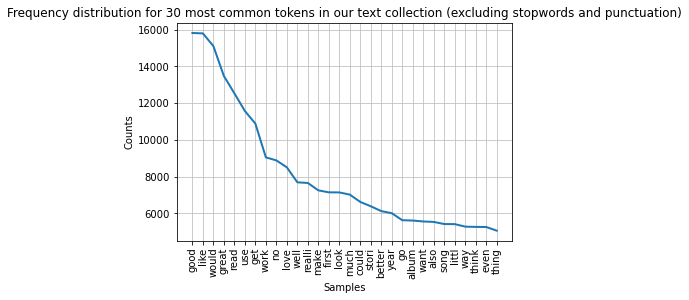

<AxesSubplot:title={'center':'Frequency distribution for 30 most common tokens in our text collection (excluding stopwords and punctuation)'}, xlabel='Samples', ylabel='Counts'>

In [14]:
c = " ".join([w for w in train_df_s['review_full']])

fdist_filtered = FreqDist([ w for w in c.split()])
fdist_filtered.plot(30,title='Frequency distribution for 30 most common tokens in our text collection (excluding stopwords and punctuation)')


## Machine Learning

### Train test split

In [15]:
corpus = train_df_s['review_full']

vectorizer = CountVectorizer()
tfidf = TfidfTransformer()

X = Pipeline([
    ('count_vectorizer', vectorizer),
    ('tfidf_transformer', tfidf)
]).fit_transform(corpus)



y = train_df_s['class_index']


# 70% for training and 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)



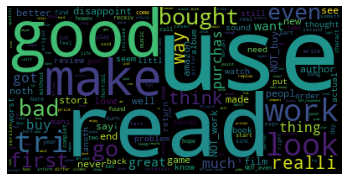

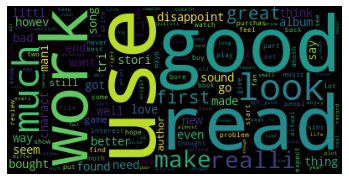

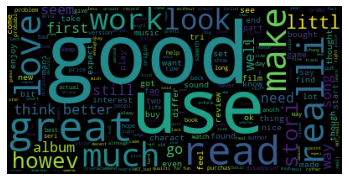

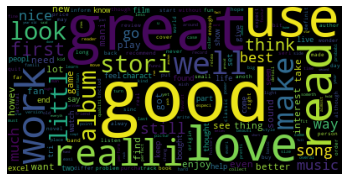

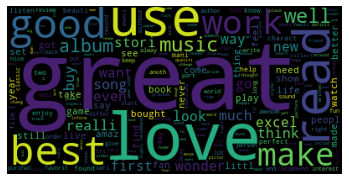

In [ ]:
for i in range(1,6):
  wordcloud = WordCloud().generate(" ".join(corpus[j] for j in range(0, len(corpus)) if train_df_s['class_index'][j] == i ))
  plt.figure()
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

## Test split

In [22]:
n_samples = 20000

test_df_s = test_df.sample(n=n_samples)
test_df_s.reset_index(drop=True, inplace=True)

test_df_s['review_full']= test_df_s['review_title'] + ' ' + test_df_s['review_text']


for i, review_full in tqdm(enumerate(test_df_s['review_full'])):
    preprocess_text = preprocess_data(review_full)
    test_df_s['review_full'][i] = preprocess_text

corpus = test_df_s['review_full']

X_test =  Pipeline([
    ('count_vectorizer', vectorizer),
    ('tfidf_transformer', tfidf)
]).transform(corpus)

y_test = test_df_s['class_index']



20000it [00:29, 673.73it/s]


In [18]:
test_df_s

,class_index,review_title,review_text,review_full
0,4,Good buy,Does all you need for that person that just ne...,good buy need person need trim without expert...
1,5,Love it!,"Fun, makes you sweat - real people on the danc...",love fun make sweat real peopl danc floor eas...
2,3,"Not bad, but not all that","I enjoyed this movie, but it's not very scary....",NOT_bad NOT_enjoy NOT_scari also bit slow spo...
3,4,Well-made,I bought this for my shepherd-rottweiler mix w...,well made bought shepherd rottweil mix driven...
4,5,This Suit ROCKS!,We've all had lives that sometimes are a bit d...,suit rock live sometim bit differ bob pari wr...
...,...,...,...,...
19995,4,EXCELLENT,"LOVE THIS WORK OUT , CHALLENGING AND EFFECTIVE...",excel love work challeng effectivei start add...
19996,2,Heavy and Slippery,I have wanted a pair of Sorel boots for as lon...,heavi slipperi want pair sorel boot long reme...
19997,4,Finally - Wayne Wonder,"Took a while, but I am glad that one of my fav...",final wayn wonder took glad favorit singer fi...
19998,4,Nas and Dre on a whole album - Very good,Dre's album after DeathRow and before signing ...,na dre whole album good dre album deathrow si...


### Naive Bayes


Test score:  0.4762
Test accuracy:  0.4762
Test accuracy:  [[2323 1129  282  115  130]
 [ 874 1757  953  284  141]
 [ 420 1008 1538  817  265]
 [ 206  358  866 1622  891]
 [ 206  193  286 1052 2284]]


Text(0, 0.5, 'predictions')

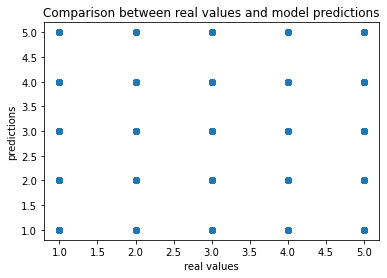

In [91]:
mnb_model = MultinomialNB().fit(X, y)

y_pred = mnb_model.predict(X_test)

test_score_mnb = mnb_model.score(X_test, y_test)
print('Test score: ', test_score_mnb)
print('Test accuracy: ', accuracy_score(y_test, y_pred))
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred))

plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Comparison between real values and model predictions')
plt.xlabel('real values')
plt.ylabel('predictions')



In [81]:
print(train_df_s['weight'].shape)

(50000,)


### Decision Tree


In [85]:
dtc_model = DecisionTreeClassifier().fit(X, y)
y_pred = dtc_model.predict(X_test)
test_score_dct = mnb_model.score(X_test, y_pred)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Test score: ', test_score_dct)
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred))


Accuracy:  0.31055
Test score:  0.3242


### Neural Networks


In [25]:
nn_model = MLPClassifier().fit(X, y)
y_pred = nn_model.predict(X_test)
test_score_nn = nn_model.score(X_test, y_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Test score: ', test_score_nn)
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred))


0.4238
Test score:  0.4238


### Suport Vector Machine

In [87]:
sgdc_model = MLPClassifier().fit(X, y)
y_pred = sgdc_model.predict(X_test)
test_score_sgdc = sgdc_model.score(X_test, y_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Test score: ', test_score_sgdc)
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred))


0.42505
Test score:  0.42505


### K Nearest Neighbors

In [89]:
knc_model = KNeighborsClassifier().fit(X, y)
y_pred = knc_model.predict(X_test)
test_score_knc = knc_model.score(X_test, y_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Test score: ', test_score_knc)
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred))


0.3137
Test score:  0.3137


### Logistic Regression

In [90]:
lr_model = LogisticRegression().fit(X, y)
y_pred = lr_model.predict(X_test)
test_score_lr = lr_model.score(X_test, y_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Test score: ', test_score_lr)
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred))


0.48275
Test score:  0.48275


/Users/beatrizag__/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Results

performance on the test set, confusion matrix, precision, recall, accuracy, F1 measure, time spent to train/test the models

At least 3 machine learning algorithms should be employed (Naïve Bayes, Decision Trees, Neural Networks, K-NN, SVM, ...), **matching them with the different ways of generating the dataset**